<a href="https://colab.research.google.com/github/StevenVuong/MSc_Project/blob/master/p4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook is meant for the analysis and comparison of the different models and parameter selections**

In [0]:
# standard imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# to mount our drive
from google.colab import drive

In [2]:
# mount google drive
drive.mount('/content/gdrive')

os.chdir('/content')

# go to where the data is
print (os.listdir())
os.chdir('gdrive/My Drive/msc_project')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
['.config', 'gdrive', 'sample_data']


In [3]:
# read metrics file, format: [val_loss,val_acc, train_loss, train_acc, test_loss, test_acc]
metrics_df = pd.read_csv('stored_metrics/metrics0.csv', header=None)

# relabel headers
metrics_df.columns = ['val_loss', 'val_acc', 'train_loss', 'train_acc', 'test_loss', 'test_acc']
metrics_df.head()

,val_loss,val_acc,train_loss,train_acc,test_loss,test_acc
0,5.641333,0.650000,5.712752,0.645570,1.465282,0.909091
1,11.028171,0.315789,6.492011,0.597222,5.861125,0.636364
2,8.059048,0.500000,5.820423,0.638889,4.835429,0.700000
3,6.786567,0.578947,3.605364,0.776316,4.395844,0.727273
4,2.686349,0.833333,5.372699,0.666667,4.835429,0.700000


In [12]:
# aggregate so we have the averages of each batch
batch_mean_df = metrics_df.groupby(np.arange(len(metrics_df))//5).mean()

# only want to take the last 30 (we only trained for 30 epochs, filter noise)
batch_mean_df = batch_mean_df.tail(30)
batch_mean_df.head()

,val_loss,val_acc,train_loss,train_acc,test_loss,test_acc
46,1.271597,0.596023,0.942350,0.617333,1.522589,0.567273
47,0.697249,0.634327,0.768637,0.638125,0.762024,0.650909
48,0.661748,0.702047,0.579841,0.689833,0.815332,0.645455
49,0.542593,0.723158,0.628185,0.674974,0.675838,0.683636
50,0.727871,0.677427,0.525233,0.733232,0.549591,0.712727


**Below is the performance of our train/test/validation sets, quite impressive**

In [13]:
# get the final output (model at end)
batch_mean_df.iloc[-1,:]

val_loss      0.000795
val_acc       1.000000
train_loss    0.000753
train_acc     1.000000
test_loss     0.000631
test_acc      1.000000
Name: 75, dtype: float64

**Plot accuracy and noise for train/test/validation sets**

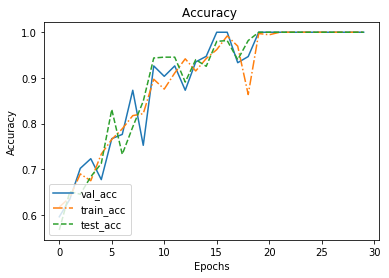

In [14]:
# plotting the accuracy
plt.plot(batch_mean_df.val_acc.values, label='val_acc', ls='-')
plt.plot(batch_mean_df.train_acc.values, label='train_acc', ls='-.')
plt.plot(batch_mean_df.test_acc.values, label='test_acc', ls='--')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy ')

plt.legend(loc='lower left')

plt.show()

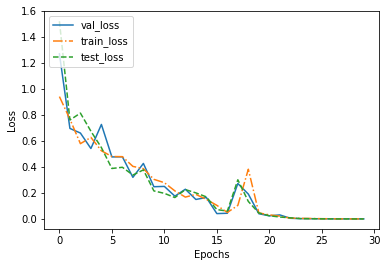

In [15]:
# plotting the loss
plt.plot(batch_mean_df.val_loss.values, label='val_loss', ls='-')
plt.plot(batch_mean_df.train_loss.values, label='train_loss', ls='-.')
plt.plot(batch_mean_df.test_loss.values, label='test_loss', ls='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(loc='upper left')

plt.show()